In [2]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from modelutils import *
from quant import *
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from dataclasses import dataclass
from torch.utils.data import SubsetRandomSampler

c:\Users\igor-\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\utils\_runtime.py:185: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [3]:


DEBUG = True 

@dataclass
class Args(object):
    nsamples: int = 16
    sparsity = 0.3
    prunen: int = 0
    prunem: int = 0
    percdamp = .01
    blocksize: int = 16
    batch_size: int = 16
    num_layers: int = 5
    num_blocks: int = 4
    input_size: int = 784
    output_size: int = 10
    minlayer: int = -1
    maxlayer: int = 1000
    prune_only: str = ""
    invert: bool = False
args = Args()
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


In [4]:
# Step 1: Data Preparation
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=False)

# Confirm if data is loaded
len(trainset), len(testset)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


In [52]:
class FCBlock(nn.Module):
    def __init__(self, input_size = 28*28, output_size = 28*28, num_layers = 4):
        super(FCBlock, self).__init__()
        # self.fc_layers = nn.Sequential(
        #     *([nn.Linear(input_size, output_size), nn.ReLU()]*num_layers) 
        # )        
        # self.fc_layers = [nn.Linear(input_size, output_size) for _ in range(num_layers)]
        # self.fc_layers = nn.ModuleList(self.fc_layers)
        # self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, output_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(output_size, output_size)
        self.relu2 = nn.ReLU()
        # self.fc_layers = nn.Sequential(*[nn.ReLU(nn.Linear(input_size, output_size)) for _ in range(num_layers)])    
    def forward(self, x):
        # for layer in self.fc_layers:
        #     x = layer(x)
        #     x = self.relu(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        # self.fc_layers(x)
        return x

class MLP(nn.Module):
    def __init__(self, input_size=28*28, output_size=10, num_blocks = 4, num_layers = 4):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size

        self.blocks = [FCBlock(num_layers = num_layers) for _ in range(num_blocks)]
        out = nn.Linear(input_size, output_size)
        self.blocks.append(out)
        self.blocks = nn.ModuleList(self.blocks)
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        for fcblock in self.blocks[:-1]:
            x = fcblock(x)
        x = self.blocks[-1](x)
        return x

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP2, self).__init__()
        # Create a list of fully connected layers based on the sizes provided

        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        # Unpack the layers list into nn.Sequential, which will manage the layers for us
        self.layers = nn.Sequential(*layers)
        # Normalization layers, assuming we want to apply these at the end of the network
        self.norm = nn.LayerNorm(output_size, elementwise_affine=True)

    def forward(self, x):
        x = x.view(-1, args.input_size)
        x = self.layers(x)
        x = self.norm(x)
        return x


In [53]:

# Example usage:
input_size = args.input_size
hidden_sizes = [args.input_size]*args.num_layers  # Example layer sizes, similar to what's shown in the image
output_size = args.output_size
model = MLP2(input_size, hidden_sizes, output_size).to(device)


In [6]:
# model = DynamicMLP(num_layers=args.num_layers).to(device)
# model = BlockDynamicMLP(input_size=28*28, output_size=10, num_blocks=4, num_layers=args.num_layers).to(device)
model = MLP(num_blocks = args.num_blocks, num_layers = args.num_layers).to(device)


In [54]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 2
train_losses, test_losses = [], []

In [55]:
model

MLP2(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=784, bias=True)
    (3): ReLU()
    (4): Linear(in_features=784, out_features=784, bias=True)
    (5): ReLU()
    (6): Linear(in_features=784, out_features=784, bias=True)
    (7): ReLU()
    (8): Linear(in_features=784, out_features=784, bias=True)
    (9): ReLU()
    (10): Linear(in_features=784, out_features=10, bias=True)
  )
  (norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
)

In [56]:
model

MLP2(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=784, bias=True)
    (3): ReLU()
    (4): Linear(in_features=784, out_features=784, bias=True)
    (5): ReLU()
    (6): Linear(in_features=784, out_features=784, bias=True)
    (7): ReLU()
    (8): Linear(in_features=784, out_features=784, bias=True)
    (9): ReLU()
    (10): Linear(in_features=784, out_features=10, bias=True)
  )
  (norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
)

In [57]:
layers_dict = find_layers(model)
layers_dict

{'layers.0': Linear(in_features=784, out_features=784, bias=True),
 'layers.2': Linear(in_features=784, out_features=784, bias=True),
 'layers.4': Linear(in_features=784, out_features=784, bias=True),
 'layers.6': Linear(in_features=784, out_features=784, bias=True),
 'layers.8': Linear(in_features=784, out_features=784, bias=True),
 'layers.10': Linear(in_features=784, out_features=10, bias=True)}

In [58]:
MODEL_NAME = "block_dynamic_mnist_mlp.pth"
LOAD = False

if not(LOAD):
    SAVE = True
else:
    SAVE = False

Epoch 1/2.. Train loss: 0.688.. Test loss: 0.257.. Test accuracy: 0.926
Epoch 2/2.. Train loss: 0.212.. Test loss: 0.201.. Test accuracy: 0.945
Finished Training


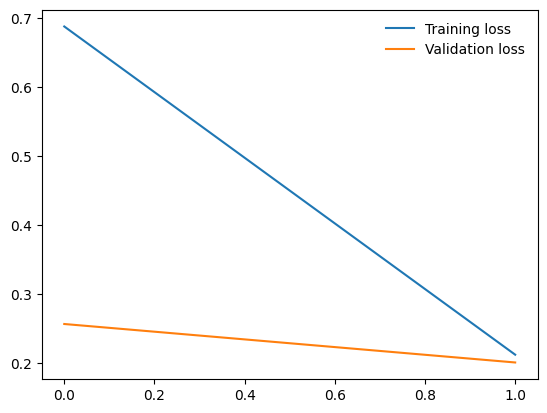

In [59]:
if LOAD:
    PATH = f'./{MODEL_NAME}'
    model.load_state_dict(torch.load(PATH))
else:    
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            output = model(images.to(device))
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for images, labels in testloader:
                    log_ps = model(images.to(device))
                    test_loss += criterion(log_ps, labels.to(device))
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.to(device).view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print(f"Epoch {e+1}/{epochs}.. "
                f"Train loss: {running_loss/len(trainloader):.3f}.. "
                f"Test loss: {test_loss/len(testloader):.3f}.. "
                f"Test accuracy: {accuracy/len(testloader):.3f}")

    print('Finished Training')
    if SAVE:
        PATH = f'./{MODEL_NAME}'
        torch.save(model.state_dict(), PATH)
        plt.plot(train_losses, label='Training loss')
        plt.plot(list(map(torch.Tensor.cpu, test_losses)), label='Validation loss')
        plt.legend(frameon=False)
        plt.show()


In [65]:
def infer_and_compute_accuracy_random_samples(model, dataset, num_samples=1000):
    model.eval()  # Set the model to evaluation mode
    
    # Create a list of indices and shuffle them
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    idx = indices[:num_samples]

    # Create a DataLoader with SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    testloader_random_samples = DataLoader(dataset, batch_size=args.batch_size, sampler=sampler)

    correct_count, all_count = 0, 0
    for images, labels in testloader_random_samples:
        with torch.no_grad():
            outputs = model(images.view(images.shape[0], -1).to(device))
        
        _, predicted = torch.max(outputs, 1)
        correct_count += (predicted == labels.to(device)).sum().item()
        all_count += labels.size(0)
    
    print("Number of Samples tested =", all_count)
    print("\nModel Accuracy =", (correct_count / all_count))

# Assuming testset is your test dataset
# Call the function
infer_and_compute_accuracy_random_samples(model, testset, num_samples=1000)


Number of Samples tested = 1000

Model Accuracy = 0.944


In [67]:
model.layers[1](torch.randn(1, 28*28).to(device)).shape


torch.Size([1, 784])

In [68]:
len(model.layers)

11

In [69]:
model.layers

Sequential(
  (0): Linear(in_features=784, out_features=784, bias=True)
  (1): ReLU()
  (2): Linear(in_features=784, out_features=784, bias=True)
  (3): ReLU()
  (4): Linear(in_features=784, out_features=784, bias=True)
  (5): ReLU()
  (6): Linear(in_features=784, out_features=784, bias=True)
  (7): ReLU()
  (8): Linear(in_features=784, out_features=784, bias=True)
  (9): ReLU()
  (10): Linear(in_features=784, out_features=10, bias=True)
)

In [70]:
layers_dict = find_layers(model)
layers_dict

{'layers.0': Linear(in_features=784, out_features=784, bias=True),
 'layers.2': Linear(in_features=784, out_features=784, bias=True),
 'layers.4': Linear(in_features=784, out_features=784, bias=True),
 'layers.6': Linear(in_features=784, out_features=784, bias=True),
 'layers.8': Linear(in_features=784, out_features=784, bias=True),
 'layers.10': Linear(in_features=784, out_features=10, bias=True)}

In [71]:
class SparseGPT:

    def __init__(self, layer):
        self.layer = layer
        print(layer)
        print(type(layer))
        self.dev = self.layer.weight.device
        W = layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.rows = W.shape[0]
        self.columns = W.shape[1]
        self.H = torch.zeros((self.columns, self.columns), device=self.dev)
        self.nsamples = 0

    def add_batch(self, inp, out, blocksize=args.blocksize):
        if DEBUG:
            self.inp1 = inp
            self.out1 = out
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(0)
        tmp = inp.shape[0]
        if isinstance(self.layer, nn.Linear) or isinstance(self.layer, transformers.Conv1D):
            if len(inp.shape) == 3:
                inp = inp.reshape((-1, inp.shape[-1]))
            inp = inp.t()
        self.H *= self.nsamples / (self.nsamples + tmp)
        self.nsamples += tmp
        inp = math.sqrt(2 / self.nsamples) * inp.float()
        self.H += inp.matmul(inp.t())

    def fasterprune(
        self, sparsity, prunen=0, prunem=0, blocksize=args.blocksize, percdamp=.01
    ):
        W = self.layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        W = W.float()

        if hasattr(self, 'quantizer'):
            if not self.quantizer.ready():
                self.quantizer.find_params(W, weight=True)

        tick = time.time()

        H = self.H
        del self.H
        dead = torch.diag(H) == 0
        H[dead, dead] = 1
        W[:, dead] = 0

        Losses = torch.zeros(self.rows, device=self.dev)

        damp = percdamp * torch.mean(torch.diag(H))
        diag = torch.arange(self.columns, device=self.dev)
        H[diag, diag] += damp
        H = torch.linalg.cholesky(H)
        H = torch.cholesky_inverse(H)
        H = torch.linalg.cholesky(H, upper=True)
        Hinv = H

        mask = None

        for i1 in range(0, self.columns, blocksize):
            i2 = min(i1 + blocksize, self.columns)
            count = i2 - i1

            W1 = W[:, i1:i2].clone()
            Q1 = torch.zeros_like(W1)
            Err1 = torch.zeros_like(W1)
            Losses1 = torch.zeros_like(W1)
            Hinv1 = Hinv[i1:i2, i1:i2]

            if prunen == 0: 
                if mask is not None:
                    mask1 = mask[:, i1:i2]
                else:
                    tmp = W1 ** 2 / (torch.diag(Hinv1).reshape((1, -1))) ** 2
                    thresh = torch.sort(tmp.flatten())[0][int(tmp.numel() * sparsity)]
                    mask1 = tmp <= thresh
            else:
                mask1 = torch.zeros_like(W1) == 1

            for i in range(count):
                w = W1[:, i]
                d = Hinv1[i, i]

                if prunen != 0 and i % prunem == 0:
                    tmp = W1[:, i:(i + prunem)] ** 2 / (torch.diag(Hinv1)[i:(i + prunem)].reshape((1, -1))) ** 2
                    mask1.scatter_(1, i + torch.topk(tmp, prunen, dim=1, largest=False)[1], True)

                q = w.clone()
                q[mask1[:, i]] = 0

                if hasattr(self, 'quantizer'):
                    q = quantize(
                        q.unsqueeze(1), self.quantizer.scale, self.quantizer.zero, self.quantizer.maxq
                    ).flatten()

                Q1[:, i] = q
                Losses1[:, i] = (w - q) ** 2 / d ** 2

                err1 = (w - q) / d
                W1[:, i:] -= err1.unsqueeze(1).matmul(Hinv1[i, i:].unsqueeze(0))
                Err1[:, i] = err1

            W[:, i1:i2] = Q1
            Losses += torch.sum(Losses1, 1) / 2

            W[:, i2:] -= Err1.matmul(Hinv[i1:i2, i2:])

            if DEBUG:
                self.layer.weight.data[:, :i2] = W[:, :i2]
                self.layer.weight.data[:, i2:] = W[:, i2:]
                print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))
                print(torch.sum(Losses))

        torch.cuda.synchronize()
        print('time %.2f' % (time.time() - tick))
        print('error', torch.sum(Losses).item())

        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.layer.weight.data = W.reshape(self.layer.weight.shape).to(self.layer.weight.data.dtype)
        if DEBUG:
            print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))

    def free(self):
        if DEBUG:
            self.inp1 = None
            self.out1 = None
        self.H = None
        torch.cuda.empty_cache()


In [73]:
indices = list(range(len(testset)))
np.random.shuffle(indices)
idx = indices
# sampler = SubsetRandomSampler(idx)
# calibration_loader = DataLoader(testset, batch_size=args.nsamples, sampler=sampler)
calibration_loader = DataLoader(testset, batch_size=args.batch_size, shuffle=False)

In [82]:
# model = MLP(num_blocks = args.num_layers).to(device)
model = MLP2(input_size, hidden_sizes, output_size).to(device)
model.load_state_dict(torch.load(f"./{MODEL_NAME}"))

<All keys matched successfully>

In [83]:
@torch.no_grad()
def mlp_sequential(model, dataloader, dev):
    print('Starting ...')

    # use_cache = model.config.use_cache
    # model.config.use_cache = False
    # layers = model.transformer.h
    layers = model.layers
    print("layers: ", layers)
    # model.transformer.word_embeddings = model.transformer.word_embeddings.to(dev)
    # model.transformer.word_embeddings_layernorm = model.transformer.word_embeddings_layernorm.to(dev)
    layers[0] = layers[0].to(dev)
    
    print("layers[0]: ", layers[0])
    layers[0] = layers[0].to(dev)

    dtype = next(iter(model.parameters())).dtype
    inps = torch.zeros(
        (args.nsamples, args.nsamples, 28*28), dtype=dtype, device=dev
    )
    # cache = {'i': 0, 'attention_mask': None, 'alibi': None}
    cache = {'i': 0}

    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, inp, **kwargs):
            # print("inps cache: ", inps[cache['i']])
            # if cache['i'] == args.nsamples - 1:
            #     raise ValueError
            if cache['i'] < args.nsamples:
                inps[cache['i']] = inp
                cache['i'] += 1
            # cache['attention_mask'] = kwargs['attention_mask']
            # cache['alibi'] = kwargs['alibi']
            raise ValueError
    layers[0] = Catcher(layers[0])
    for i, batch in enumerate(dataloader):
        try:
            print(i)
            # print(batch[0].shape)
            model(batch[0].to(dev))
        except ValueError:
            pass
    layers[0] = layers[0].module

    layers[0] = layers[0].cpu()
    # model.transformer.word_embeddings = model.transformer.word_embeddings.cpu()
    # model.transformer.word_embeddings_layernorm = model.transformer.word_embeddings_layernorm.cpu()
    torch.cuda.empty_cache()

    outs = torch.zeros_like(inps)
    # attention_mask = cache['attention_mask']
    # alibi = cache['alibi']

    print('Ready.')

    for i in range(len(layers)-1):
        layer = layers[i].to(dev)
        print(i, " ", layer)
        subset = find_layers(layer)
        gpts = {}
        print(gpts)
        for name in subset:
            if (not (args.minlayer <= i < args.maxlayer and args.prune_only in name)) == (not args.invert):
                continue
            # elif isinstance(subset[name], nn.Linear) and subset[name].out_features == 10:
            #     continue
            gpts[name] = SparseGPT(subset[name])

        def add_batch(name):
            def tmp(_, inp, out):
                gpts[name].add_batch(inp[0].data, out.data)
            return tmp
        handles = []
        for name in gpts:
            handles.append(subset[name].register_forward_hook(add_batch(name)))
        for j in range(args.nsamples):
            # outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask, alibi=alibi)[0]
            outs[j] = layer(inps[j].unsqueeze(0))[0]
        for h in handles:
            h.remove()

        for name in gpts:
            print(i, name)
            print('pruning ...')
            gpts[name].fasterprune(
                args.sparsity, prunen=args.prunen, prunem=args.prunem, percdamp=args.percdamp
            )
        for j in range(args.nsamples):
            # outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask, alibi=alibi)[0]
            outs[j] = layer(inps[j].unsqueeze(0))[0]

        layers[i] = layer.cpu()
        del gpts 
        torch.cuda.empty_cache()

        inps, outs = outs, inps

    # model.config.use_cache = use_cache

In [84]:
mlp_sequential(model, calibration_loader, device)

Starting ...
layers:  Sequential(
  (0): Linear(in_features=784, out_features=784, bias=True)
  (1): ReLU()
  (2): Linear(in_features=784, out_features=784, bias=True)
  (3): ReLU()
  (4): Linear(in_features=784, out_features=784, bias=True)
  (5): ReLU()
  (6): Linear(in_features=784, out_features=784, bias=True)
  (7): ReLU()
  (8): Linear(in_features=784, out_features=784, bias=True)
  (9): ReLU()
  (10): Linear(in_features=784, out_features=10, bias=True)
)
layers[0]:  Linear(in_features=784, out_features=784, bias=True)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144